## <p style="background-color:skyblue; font-family:newtimeroman; font-size:180%; text-align:center">1. Introduction</p>

Neural Machine Translation is a state-of-the-art machine translation approach that utilizes deep learning techniques to predict the likelihood of a set of words in sequence. In simple words it translates from one language to another. In the below image we see google translating from English to Hindi pretty efficiently.

<img width=700, height=700, src="https://github.com/pashupati98/kaggle-archives/blob/main/img/google%20translate.PNG?raw=true">


> This notebook is pytorch based implementation of a seq2seq machine translation model. This implementaton is based on some papers and blogs (reference at the bottom). It covers the code in as much detail as possible rather than using high level frameworks.

In [1]:
### Importing utilities
from __future__ import unicode_literals, print_function, division
import pandas as pd
import numpy as np
import time
import math
import pickle

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
from prettytable import PrettyTable

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import  nltk.translate.bleu_score as bleu
from matplotlib.font_manager import FontProperties

from io import open
import unicodedata
import string
import re
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
### Some parameters (Details in coming sections)
SOS_token = 0
EOS_token = 1
UNK_token = 2

MAX_LENGTH = 20
teacher_forcing_ratio = 0.5
hidden_size = 1000

# 2. Data Preparation 

The data for this task is a set of many English to hindi translation pairs. The Hindi-English Corpora available on Kaggle can also be used here.

In [3]:
data = open('../input/englishhindi-pairs-data/eng-hin.txt', encoding='utf-8').\
        read().strip().split('\n')
pairs = [[s for s in l.split('\t')[:2]] for l in data]
pairs[100:110]

[['I have a car.', 'मेरे पास एक गाड़ी है।'],
 ['I have a dog.', 'मेरे पास एक कुत्ता है।'],
 ['I understand.', 'मैं समझता हूँ।'],
 ["I'm a doctor.", 'मैं डॉक्टर हूँ।'],
 ['It is a book.', 'यह किताब है।'],
 ["It's snowing.", 'बरफ़ गिर रही है।'],
 ["It's too big.", 'बहुत ज़्यादा बड़ा है।'],
 ['Please leave.', 'कृपया जाईये।'],
 ['Unbelievable!', 'अविश्वसनीय!'],
 ['We are happy.', 'हम खुश हैं।']]

Now, we need the data in a format that is easy to process and feed. We’ll need a unique index per word to use as the inputs and targets of the networks later. To keep track of all this we will use a helper class called Lang which has word → index (word2index) and index → word (index2word) dictionaries, as well as a count of each word word2count to use to later replace rare words.

In [4]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

A function to turn Unicode characters to ASCII if needed. Another function to make everything lowercase, and trim most punctuation.

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

A function to read the data and to create objects of the Lang Class

In [6]:
def readLangs(lang1, lang2, reverse=False):
    print("Started Loading Data...")
    print("Reading lines...")

    
   # Read the file and split into lines
    lines = open('../input/englishhindi-pairs-data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    
    #print(lines)

    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')[:2]] for l in lines]
    
    #print(pairs)
    
   
    print("len", len(pairs))
    # pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

A function to filter data based on sequence lenght if needed

In [7]:
def filterPair(p):
    #print(p[1])
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH
    except:
        print("Skipped this pair : ", p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

A wrapper function to do the data preparation steps

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print("Data Loaded....See Example below - ")
print(random.choice(pairs))

Started Loading Data...
Reading lines...
len 2774
Read 2774 sentence pairs
Trimmed to 2772 sentence pairs
Counting words...
Counted words:
eng 3453
hin 3103
Data Loaded....See Example below - 
["What's the matter?", 'मुश्किल क्या है?']


In [11]:
# print("Saving Dictionary")
# pickle.dump(input_lang, open('save/input.pkl', 'wb'))
# pickle.dump(output_lang, open('save/output.pkl', 'wb'))

Utility functions to create tensors from sentences

Tensor - A tensor is a generalization of vectors and matrices and is easily understood as a multidimensional array.

In [12]:
def indexesFromSentence(lang, sentence):
    words = sentence.split(' ')
    indexes = []
    for word in words:
        if word not in lang.word2index.keys():
            indexes.append(lang.word2index["UNK"])
        else:
            indexes.append(lang.word2index[word])

    return indexes
    #return [lang.word2index[word] for word in words]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# 3. Model Architecture (The Seq2Seq Model)

A Sequence to Sequence network (also known as seq2seq network, or Encoder Decoder network) is a model consisting of two RNNs called the encoder and decoder. The encoder reads an input sequence and outputs a single vector, and the decoder reads that vector to produce an output sequence.

![model](https://machinelearningmastery.com/wp-content/uploads/2017/10/Encoder-Decoder-Architecture-for-Neural-Machine-Translation.png)

Unlike sequence prediction with a single RNN, where every input corresponds to an output, the seq2seq model frees us from sequence length and order, which makes it ideal for translation between two languages.

With a seq2seq model the encoder creates a single vector which, in the ideal case, encodes the “meaning” of the input sequence into a single vector — a single point in some N dimensional space of sentences. Let's look into the Encoder -

## The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

![](https://github.com/pashupati98/kaggle-archives/blob/main/img/gru_encoder.PNG?raw=true)

### Note - Refer this [Link](https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce) if you aren't familiar with RNN (Recurrent Neural Network), GRU, LSTM, Hidden State etc.

Let's implement an Encoder. We'll use LSTM units.

In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        # -----------------------------------------------------------------
        # self.weight_matrix = create_weight_matrix()
        # self.embedding, num_embeddings, embedding_dim = create_emb_layer(self.weight_matrix, True)
        self.embedding = nn.Embedding(input_size, hidden_size, layers)

        # -------------------------------------------------------------------
        # self.gru = nn.GRU(embedding_dim, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.layers, 1, self.hidden_size, device=device), torch.zeros(self.layers, 1, self.hidden_size, device=device)

## The Decoder

The decoder is another RNN that takes the encoder output vector(s) and outputs a sequence of words to create the translation. In the simplest seq2seq decoder we use only last output of the encoder. This last output is sometimes called the context vector as it encodes context from the entire sequence. This context vector is used as the initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and hidden state. The initial input token is the start-of-string <SOS> token, and the first hidden state is the context vector (the encoder’s last hidden state).
    
![decoder](https://github.com/pashupati98/kaggle-archives/blob/main/img/decoder.PNG?raw=true)
    
Let's implement the decoder using LSTM units.

In [14]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

We know have both Encoder and Decoder with us. We can go ahead and train the model. But before that Let's look into the concepts of Attention.

### Attention 

If only the context vector is passed betweeen the encoder and decoder, that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to “focus” on a different part of the encoder’s outputs for every step of the decoder’s own outputs. First we calculate a set of attention weights. These will be multiplied by the encoder output vectors to create a weighted combination. The result (called attn_applied in the code) should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

![attn](https://github.com/pashupati98/kaggle-archives/blob/main/img/attn.PNG?raw=true)

Let's implement a decoder with attention. We'll use this decoder for our final model.

In [15]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, layers=1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.layers = layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        #print("d0", embedded.shape)
        # print("d1", embedded[0].shape)
        # print("d2----", hidden[0][0].shape)
        #
        # m = torch.cat((embedded[0], hidden[0][0]), 1)
        # print("d3", m.shape)
        # r = self.attn(m)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)

        # print("d4", attn_weights.shape)
        # print("d5", encoder_outputs.unsqueeze(0).shape)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.layers, 1, self.hidden_size, device=device), torch.zeros(self.layers, 1, self.hidden_size, device=device)

### Training utility

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the <SOS> token as its first input, and the last hidden state of the encoder as its first hidden state.

In [16]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

The whole training process will go like this:

- Start a timer
- Initialize optimizers and criterion
- Create set of training pairs
- Start empty losses array for plotting

Then we call train many times and occasionally print the progress (% of examples, time so far, estimated time) and average loss.

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #print(plot_losses)
    showPlot(plot_losses)
    #pickle.dump(plot_losses, open('save/gru1n.pkl', 'wb'))

### Evaluation Utility

Evaluation is mostly the same as training, but there are no targets so we simply feed the decoder’s predictions back to itself for each step. Every time it predicts a word we add it to the output string, and if it predicts the EOS token we stop there. We also store the decoder’s attention outputs for display later.

In [18]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        # Bleu
        ref = [pair[1].split()]
        bl = bleu.sentence_bleu(ref, output_sentence.split())
        print("BLEU Score", bl)
        print('')

### Visualization Utility

Plotting is done with matplotlib, using the array of loss values plot_losses saved while training.

We can also plot the attention because it has highly interpretable outputs. It is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

In [19]:
def showPlot(points):
    #print("function called")
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.show()
    fig.savefig('loss.png')
    
def showAttention(input_sentence, output_words, attentions, attr):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    i = attentions.shape[0]
    attn = [a[:i+2].tolist() for a in attentions]

    
    cax = ax.matshow(attn, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    
    hindi_font = FontProperties(fname = '../input/nirmala-font/Nirmala.ttf')
    ax.set_yticklabels([''] + output_words, fontproperties=hindi_font)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.savefig("attention_{}.png".format(attr))
    plt.show()


def evaluateAndShowAttention(encoder1, attn_decoder1, input_sentence, attr):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions, attr)

Some helper functions to print time elapsed and estimated time remaining given the current time and progress %.

In [20]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Finally, a wrapper function to run the experiment.

In [21]:
def run_training():
    print("========== Building Encoder... ==========\n")
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size, layers=1).to(device)
    print(encoder1)
    print('\n')
    eparam = count_parameters(encoder1)
    print('\n')
    print("========== Building Decoder... ==========\n")
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, layers=1).to(device)
    print(attn_decoder1)
    print('\n')
    dparam = count_parameters(attn_decoder1)
    print("\nTotal parameters in encoder + decoder : ", eparam+dparam)
    print('\n')
    print("========== Starting Training... ==========\n")
    trainIters(encoder1, attn_decoder1, 50000, print_every=1000)
    print("========== Finished Training... ==========\n")
    # Evaluation and Visualization
    
    return encoder1, attn_decoder1

========== Building Encoder... ==========

EncoderRNN(
  (embedding): Embedding(3453, 1000, padding_idx=1)
  (lstm): LSTM(1000, 1000)
)


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  embedding.weight |  3453000   |
| lstm.weight_ih_l0 |  4000000   |
| lstm.weight_hh_l0 |  4000000   |
|  lstm.bias_ih_l0  |    4000    |
|  lstm.bias_hh_l0  |    4000    |
+-------------------+------------+
Total Trainable Params: 11461000


========== Building Decoder... ==========

AttnDecoderRNN(
  (embedding): Embedding(3103, 1000)
  (attn): Linear(in_features=2000, out_features=20, bias=True)
  (attn_combine): Linear(in_features=2000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1000, 1000)
  (out): Linear(in_features=1000, out_features=3103, bias=True)
)


+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|   embedding.weight  |  310300

<Figure size 432x288 with 0 Axes>

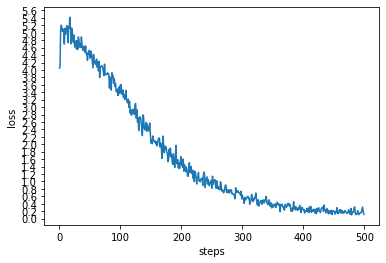

========== Finished Training... ==========



In [22]:
encoder1, attn_decoder1 = run_training()

Let's check our machine translation system on some examples

In [23]:
evaluateRandomly(encoder1, attn_decoder1)

> They are in favor of the reform of the tax laws.
= वे टैक्स सुधार क़ानून के पक्ष में हैं।
< वे टैक्स सुधार क़ानून के पक्ष में हैं। <EOS>
BLEU Score 0.8633400213704505

> Open the door.
= दरवाज़ा खोलो।
< दरवाज़ा खोलिए। <EOS>
BLEU Score 0.7598356856515925

> I don't care what they say.
= वे जो मर्ज़ी कहें मुझे उससे कोई फ़र्क नहीं पड़ता।
< वे जो मर्ज़ी कहें मुझे उससे कोई फ़र्क नहीं पड़ता। <EOS>
BLEU Score 0.8931539818068694

> Don't you think the air conditioner is turned up too high in here?
= तम्हें नहीं लगता कि एसी कुछ ज़्यादा ही तेज़ चल रहा है?
< तम्हें नहीं लगता कि एसी कुछ ज़्यादा ही तेज़ चल रहा है? <EOS>
BLEU Score 0.912167909070388

> I think that he is right.
= मुझे लगता है वह सही है।
< मुझे लगता है वह सही है। <EOS>
BLEU Score 0.8091067115702212

> He defeated his opponent in the election.
= उसने चुनाव में अपने विरोधी को हरा दिया।
< उसने चुनाव में अपने विरोधी को हरा दिया। <EOS>
BLEU Score 0.8633400213704505

> He rescued the child from the fire.
= उसने बच्चे को आग से बचाया।
< उस

The above example were from the data itself. so it perfromed really well. Let's check on some out of the data examples.

In [24]:
output_words, attentions = evaluate(
        encoder1, attn_decoder1, "He is going home")
print(" ".join(output_words))

वह अफ़वाह घर है। <EOS>


input = I can drive a car
output = मैं गाड़ी चला सकता हूँ। <EOS>


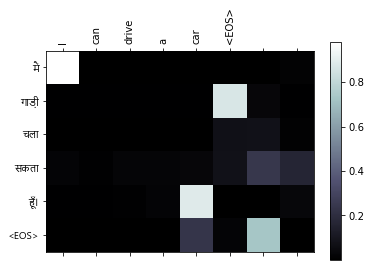

In [25]:
evaluateAndShowAttention(encoder1, attn_decoder1, "I can drive a car", "sent-1")

input = She is very beautiful
output = वह बहुत सुंदर है। <EOS>


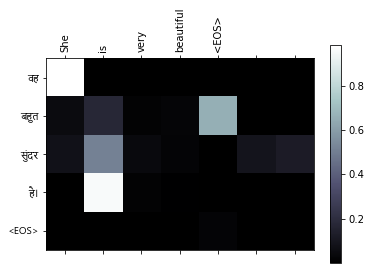

In [26]:
evaluateAndShowAttention(encoder1, attn_decoder1, "She is very beautiful", "sent-2")

input = Where are you going
output = तुम कहाँ जा रहे हो? <EOS>


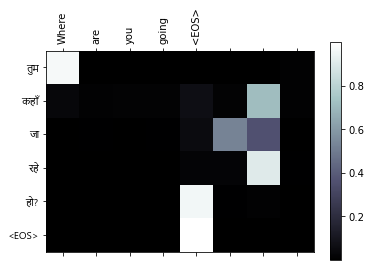

In [27]:
evaluateAndShowAttention(encoder1, attn_decoder1, "Where are you going", "sent-2")

input = Do you know him?
output = क्या तुम्हें गोली है क्या? <EOS>


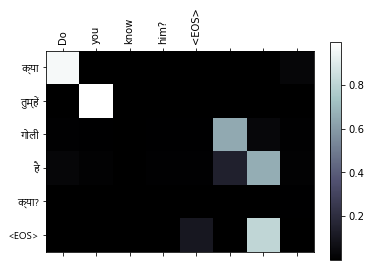

In [28]:
evaluateAndShowAttention(encoder1, attn_decoder1, "Do you know him?", "sent-2")

Conclusion - This is a very simple architecture trained a small dataset. Yet, the model has learned pretty good for small sentences. It can be futher improved by training it on large corpus.

### If you found this project interesting consider UPVOTING it. Thanks!

References 
- Ilya Sutskever, Oriol Vinyals, Quoc V. Le Sequence to sequence learning with neural networks
- Dzmitry Bahdanau, KyungHyun Cho, Yoshua Bengio∗ (2016) Neural machine translation by jointly learning to align and translate

Happy Learning!